# Code Challenge - Meta Parameters - effects of Mini batches on Wine Quality Dataset

Run same parametric experiment on wine preprocessed wine quality dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [66]:
def preprocess_data(data):
    
    # preprocess data as before
    data = data[data['total sulfur dioxide'] < 200]
    zscoreCols = data.keys().drop('quality')
    data[zscoreCols] = data[zscoreCols].apply(stats.zscore)
    data['boolQuality'] = 0
    data['boolQuality'][data['quality']>5] = 1 
    data_t = torch.tensor(data[zscoreCols].values).float()
    labels = torch.tensor(data['boolQuality'].values).float()
    labels = labels[:, None]
    return data_t, labels

def load_data(data, labels):
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, shuffle=True)

    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    
    return train_data,  testLoader

In [67]:
# a function that creates the ANN model

def createANewModel():

    # model architecture
    ANNiris = nn.Sequential(
      nn.Linear(11,32),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(32,32),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(32,1),   # output units
        )

    # loss function
    lossfun = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

    return ANNiris,lossfun,optimizer

In [79]:
# train the model

def trainTheModel(ANNiris, lossfun, optimizer, train_loader, test_loader):

    # initialize accuracies as empties
    trainAcc = []
    testAcc  = []
    losses   = []

    # loop over epochs
    for epochi in range(numepochs):

    # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
            batchLoss.append( loss.item() )
            # end of batch loop...
        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
#         predlabels = torch.argmax( ANNiris(X),axis=1 )
        testAcc.append( 100*torch.mean(((ANNiris(X)>0) == y).float()).item() )

    # function output
    return trainAcc,testAcc,losses

In [80]:
def miniBatchExp(test_loader, train_data, bs=16):
    train_loader = DataLoader(train_data,batch_size=bs,shuffle=True,drop_last=True)
    
    # create a model
    ANNiris,lossfun,optimizer = createANewModel()

    # train the model
    trainAcc,testAcc,losses = trainTheModel(ANNiris, lossfun, optimizer, train_loader, test_loader)
    
    return trainAcc, testAcc

In [81]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')

data, labels = preprocess_data(data)
train_data, testLoader = load_data(data, labels)

In [83]:
numepochs = 500

bs = 2**np.arange(1,7)
train_acc = np.zeros((numepochs, len(bs)))
test_acc = np.zeros((numepochs, len(bs)))

for i in range(len(bs)):
    tr, ts = miniBatchExp(testLoader, train_data, int(bs[i]))
    train_acc[:, i] = tr
    test_acc[:, i] = ts

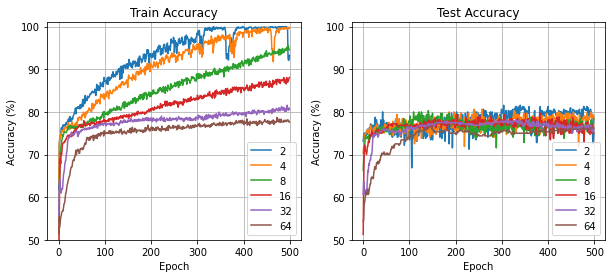

In [84]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(10, 4))


ax[0].plot(train_acc)
ax[0].set_title('Train Accuracy')
ax[1].plot(test_acc)
ax[1].set_title('Test Accuracy')


# common features
for i in range(2):
    ax[i].legend(bs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

# Code Challenge - Add batchNorm to ANN Multilayer

In [ ]:
# import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

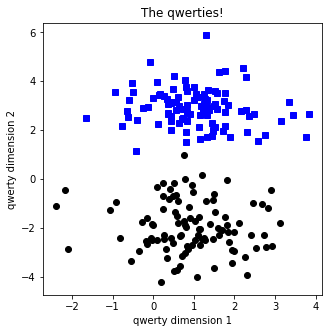

In [86]:
# create data

nPerClust = 100
blur = 1

A = [  1,  3 ]
B = [  1, -2 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [93]:
def createANNmodel(learningRate):

  # model architecture
  ANNclassify = nn.Sequential(
      nn.Linear(2,16),  # input layer
      nn.ReLU(),        # activation unit
      nn.BatchNorm1d(16),
      nn.Linear(16,1),  # hidden layer
      nn.ReLU(),        # activation unit
#       nn.BatchNorm1d(1),
      nn.Linear(1,1),   # output unit
      nn.Sigmoid(),     # final activation unit
        )

  # loss function
  lossfun = nn.BCELoss() # but better to use BCEWithLogitsLoss

  # optimizer
  optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)

  # model output
  return ANNclassify,lossfun,optimizer

In [94]:
# a function that trains the model

# a fixed parameter
numepochs = 1000

def trainTheModel(ANNmodel):

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = ANNmodel(data)

    # compute loss
    loss = lossfun(yHat,labels)
    losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  
  
  # final forward pass
  predictions = ANNmodel(data)
    
  # compute the predictions and report accuracy
  # NOTE: Wasn't this ">0" previously?!?!
  totalacc = 100*torch.mean(((predictions>.5) == labels).float())
  
  return losses,predictions,totalacc

Final accuracy: 99.5%


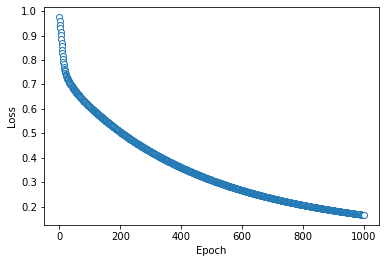

In [95]:
# create everything
ANNclassify,lossfun,optimizer = createANNmodel(.01)

# run it
losses,predictions,totalacc = trainTheModel(ANNclassify)

# report accuracy
print('Final accuracy: %g%%' %totalacc)


# show the losses
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

In [96]:
# learning rates
learningrates = np.linspace(.001,.1,50)

# initialize
accByLR = []
allLosses = np.zeros((len(learningrates),numepochs))


# the loop
for i,lr in enumerate(learningrates):
  
  # create and run the model
  ANNclassify,lossfun,optimizer = createANNmodel(lr)
  losses,predictions,totalacc = trainTheModel(ANNclassify)

  # store the results
  accByLR.append(totalacc)
  allLosses[i,:] = losses.detach()


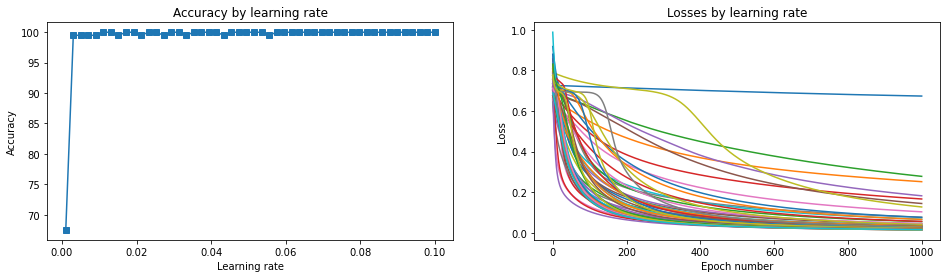

In [97]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(16,4))

ax[0].plot(learningrates,accByLR,'s-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

# Code Challenge - Activation function comparision

Compare ReLu, ReLu6 and LeakyRELU

In [79]:
def preprocess_data(data):
    
    # preprocess data as before
    data = data[data['total sulfur dioxide'] < 200]
    zscoreCols = data.keys().drop('quality')
    data[zscoreCols] = data[zscoreCols].apply(stats.zscore)
    data['boolQuality'] = 0
    data['boolQuality'][data['quality']>5] = 1 
    data_t = torch.tensor(data[zscoreCols].values).float()
    labels = torch.tensor(data['boolQuality'].values).float()
    labels = labels[:,None]
    return data_t, labels

def load_data(data, labels):
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, shuffle=True)

    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    trainLoader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    
    return trainLoader,  testLoader

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')

data, labels = preprocess_data(data)
trainLoader, testLoader = load_data(data, labels)

In [80]:
# NN with Batch Normalization

class ANN_BNorm(nn.Module):
    def __init__(self, actfn):
        super().__init__()

        self.ip = nn.Linear(11, 16)   # ip layer
        self.h1 = nn.Linear(16, 32)   # hidden layer 1
        self.h2 = nn.Linear(32, 20)  # hidden layer 2
        self.op = nn.Linear(20, 1)
        self.actfn = actfn
    
    def forward(self, x):  # doBN is bool set to true for train, and false for test
        
        actfn = getattr(torch.nn, self.actfn)
        
        x = actfn()(self.ip(x))
        x = actfn()(self.h1(x))
        x = actfn()(self.h2(x))
        
        return self.op(x)

In [81]:
# testing the model

net = ANN_BNorm('ReLU6')
net(torch.randn(10, 11)).shape

torch.Size([10, 1])

In [82]:
# training the model

nEp = 1000

def trainModel(wine_net):
    lossfn = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(wine_net.parameters(), lr = 0.01)
    
    losses = torch.zeros(nEp)
    trainAcc, testAcc = [], []
    
    for i in range(nEp):
        
        wine_net.train()
        
        batchLoss, batchAcc = [], []
        
        for x, y in trainLoader:
            
            yHat = wine_net(x)
            loss = lossfn(yHat, y)
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        wine_net.eval()
        x, y = next(iter(testLoader))
        with torch.no_grad():
            yHat = wine_net(x)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
          
    
    return trainAcc, testAcc, losses

In [83]:
af = ['ReLU', 'ReLU6', 'LeakyReLU']

trAct = np.zeros((nEp, len(af)))
teAct = np.zeros((nEp, len(af)))

for i, AFn in enumerate(af):
    net = ANN_BNorm(AFn)
    trAct[:, i], teAct[:, i], losses = trainModel(net)

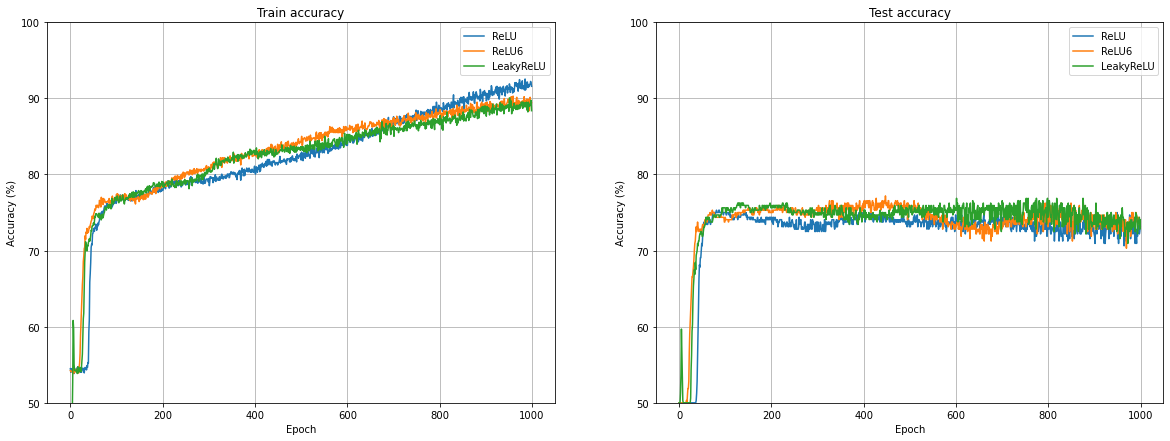

In [84]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trAct)
ax[0].set_title('Train accuracy')
ax[1].plot(teAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(af)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()

# Code Challenge - Predicting sugar

In [53]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [54]:
data['residual sugar']

0       1.9
1       2.6
2       2.3
3       1.9
4       1.9
       ... 
1594    2.0
1595    2.2
1596    2.3
1597    2.0
1598    3.6
Name: residual sugar, Length: 1599, dtype: float64

In [55]:
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns (including quality!)
zscoreCols = data.keys().drop('residual sugar')
data[zscoreCols] = data[zscoreCols].apply(stats.zscore)
zscoreCols

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [56]:
dataT = torch.tensor( data[zscoreCols].values ).float()
sugar = torch.tensor( data['residual sugar'].values ).float()
sugar = sugar[:,None] # transform to matrix

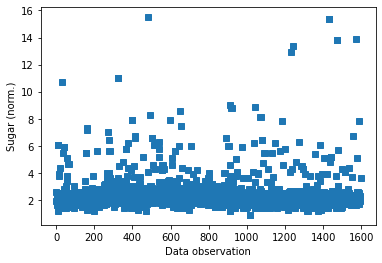

In [57]:
# check values in sugar
plt.plot(sugar,'s')
plt.xlabel('Data observation')
plt.ylabel('Sugar (norm.)')
plt.show()

In [73]:
def load_data(data, labels):
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, shuffle=True)

    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    trainLoader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    
    return trainLoader, testLoader, X_train, X_test, y_train, y_test

trainLoader, testLoader, X_train, X_test, y_train, y_test = load_data(dataT, sugar)

In [74]:
# creating model

class ANNSugar(nn.Module):
    def __init__(self):
        super().__init__()
        self.ip = nn.Linear(11, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.h1 = nn.Linear(16, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.h2 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.op = nn.Linear(16, 1)
    
    def forward(self, x, doBN=False):
        x = F.relu(self.ip(x))
        
        if doBN:
            x = self.bn1(x)
        
        x = F.relu(self.h1(x))
        
        if doBN:
            x = self.bn2(x)
        
        x = F.relu(self.h2(x))
        
        if doBN:
            x = self.bn3(x)
        
        return self.op(x)        

In [75]:
# training the model

nEp = 1000

def trainModel(ANN, doBN=False):
    
    lossfn = nn.MSELoss()
    optim = torch.optim.SGD(ANN.parameters(), lr = 0.01)
    
    trLoss, teLoss = torch.zeros(nEp), torch.zeros(nEp)
    
    for i in range(nEp):
        ANN.train()
        
        batchLoss = []
        
        for x, y in trainLoader:
            
            yHat = ANN(x, doBN)
            loss = lossfn(yHat, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
        
        trLoss[i] = np.mean(batchLoss)
        
        ANN.eval()
        
        x, y = next(iter(testLoader))
        with torch.no_grad():
            yHat = ANN(x)
        
        teLoss[i] = lossfn(yHat, y).item()
    
    return trLoss, teLoss

In [76]:
net = ANNSugar()
trLoss, teLoss = trainModel(net)

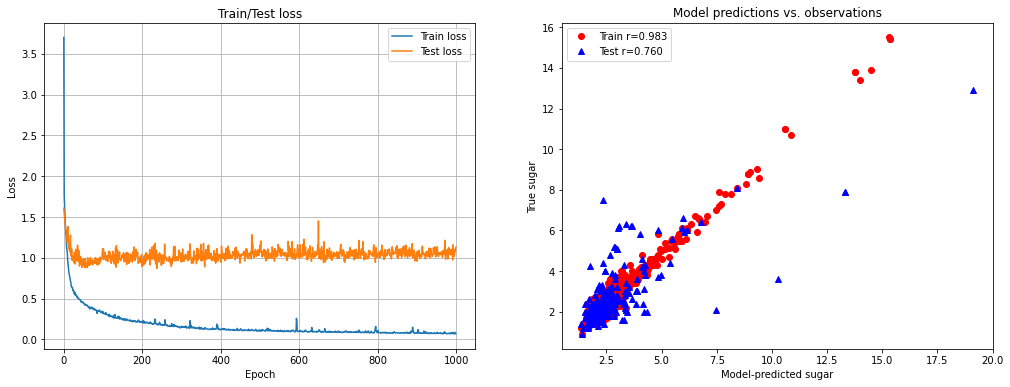

In [77]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trLoss,label='Train loss')
ax[0].plot(teLoss,label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


# show predictions and real values
yHatTrain = net(X_train)
yHatTest  = net(X_test)

ax[1].plot(yHatTrain.detach(),y_train,'ro')
ax[1].plot(yHatTest.detach(),y_test,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,y_train.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, y_test.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()

AttributeError: 'Tensor' object has no attribute 'keys'

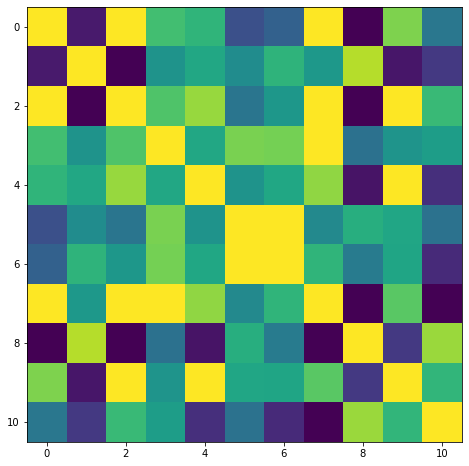

In [86]:
# Inspect the correlation matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data)),labels=data.keys(),rotation=90)
plt.yticks(range(len(data)),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()